# Mixtec Gender Classification

### Imports

In [72]:
%matplotlib inline
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from  torch.utils.data import random_split
from torchvision import datasets, transforms


### Define hardware

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda


NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 1.5 GB
Cached:    2.1 GB


### Define path to images

In [74]:
basepath = Path('/home/christan/toorange/alexwebber/mixteclabeling')
path = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'

### Load figures into dataset

In [75]:
## Load CSV
mixtec_figures = pd.read_csv(basepath / "data/mixtec_figures.csv")

print(mixtec_figures['gender'].value_counts())

## Define image transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((227, 227)),
    transforms.Grayscale()])

## Load images into PyTorch dataset
figures_dataset = datasets.ImageFolder(path, transform=transform)

print(figures_dataset)

male      429
female     45
Name: gender, dtype: int64
Dataset ImageFolder
    Number of datapoints: 210
    Root location: /home/christan/toorange/alexwebber/mixteclabeling/data/labeled_figures/codex_vindobonensis/gender
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
           )


### Assign classes to map

In [76]:
class_map = {0: "female", 1: "male"}

### Print random image for sanity check

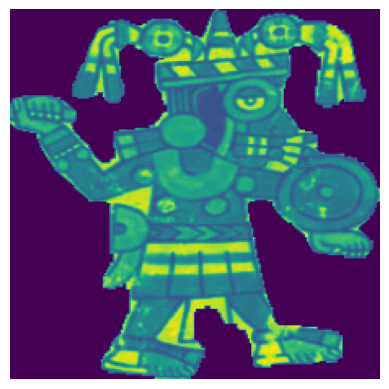

In [77]:
# Access a random image from the dataset
random_index = np.random.randint(len(figures_dataset))
image, label = figures_dataset[random_index]

# Convert the image tensor to a NumPy array and transpose it
image = image.permute(1, 2, 0)
image = image.numpy()

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

## Split datasets into training and testing sets

In [78]:
batch_size = 20

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

# Training

### Define CNN

In [79]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 56 * 56, 1568)  # Adjusted size

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 56 * 56)
        x = self.fc1(x)
        x = x.view(batch_size, -1)
        return x



# Create the model
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Define hyperparameters

In [80]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

### Train model

In [81]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        outputs = cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == 0:
            print("Epoch: " + str(epoch + 1) + " | " "Loss: " + str(running_loss))
        
            running_loss = 0.0

print('Finished Training')


Epoch: 1 | Loss: 8.004969596862793
Epoch: 2 | Loss: 3.4231998920440674
Epoch: 3 | Loss: 0.6096854209899902
Epoch: 4 | Loss: 0.4733348488807678
Epoch: 5 | Loss: 0.41015490889549255
Epoch: 6 | Loss: 0.46633607149124146
Epoch: 7 | Loss: 0.5374788045883179
Epoch: 8 | Loss: 0.5218164324760437
Epoch: 9 | Loss: 0.4996909499168396
Epoch: 10 | Loss: 0.4745522439479828
Finished Training


### View incorrectly labeled samples

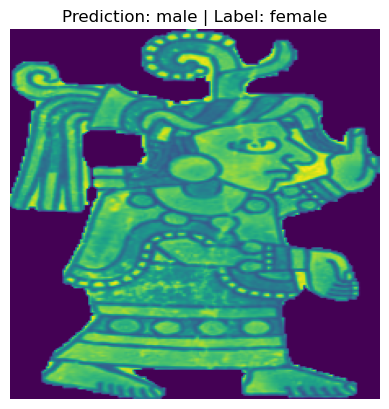

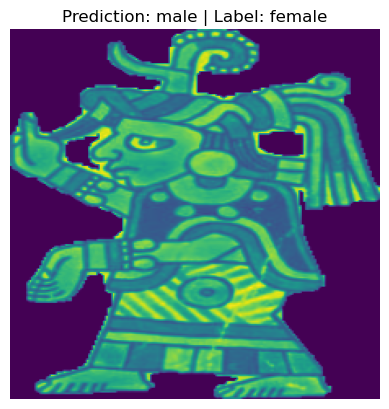

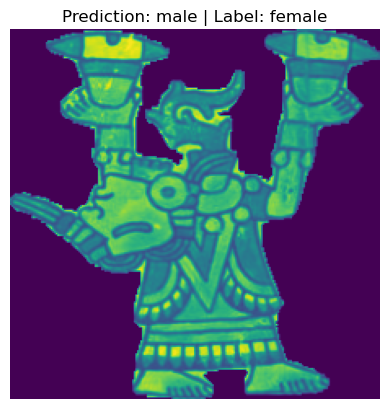

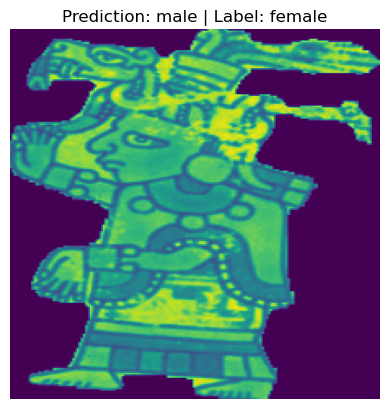

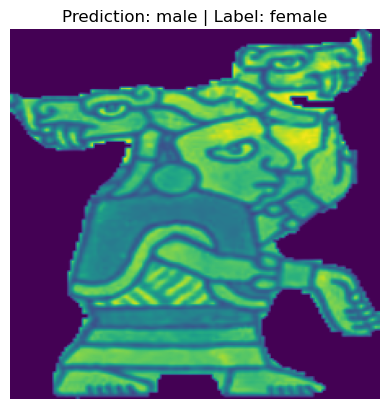

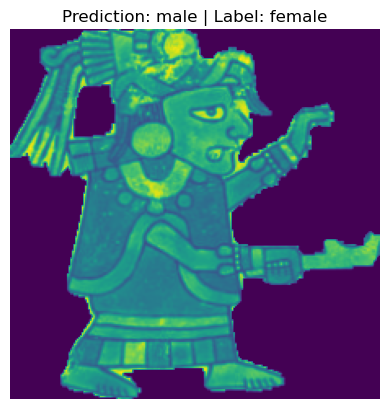

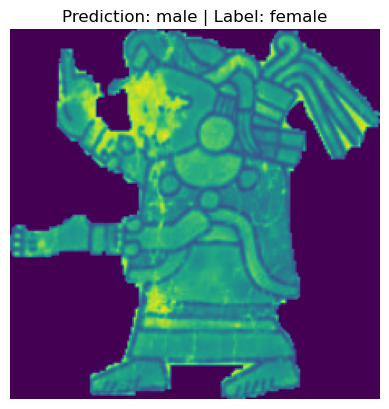

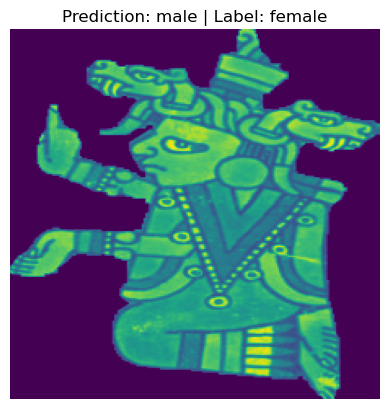

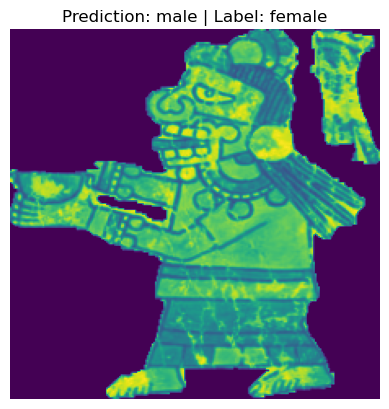

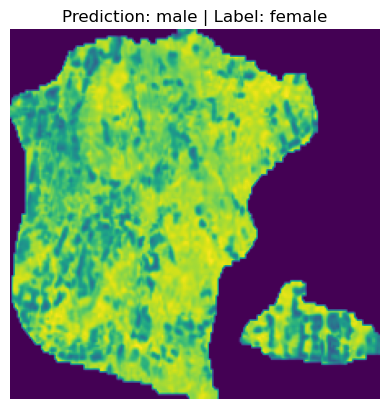

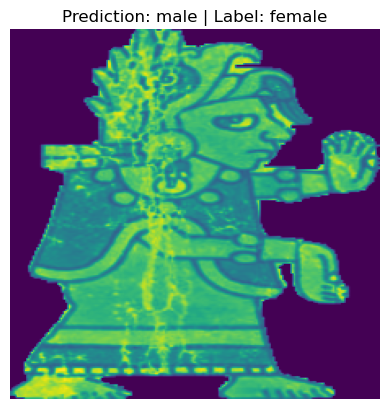

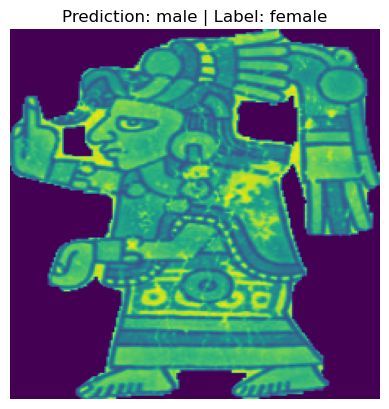

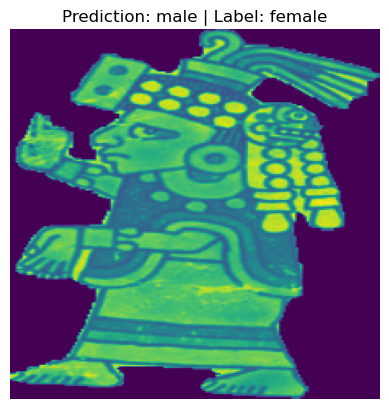

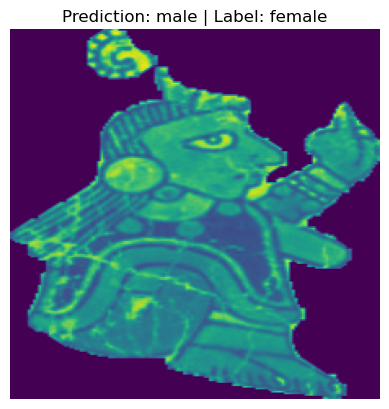

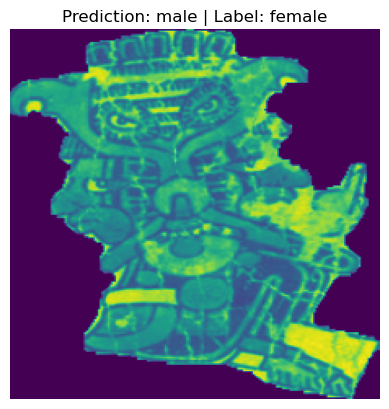

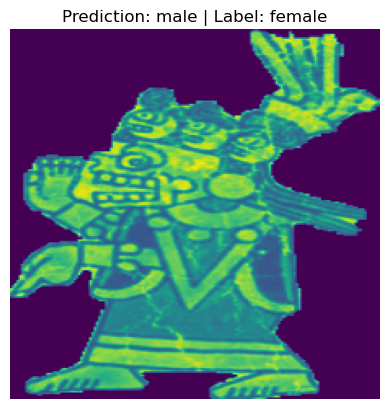

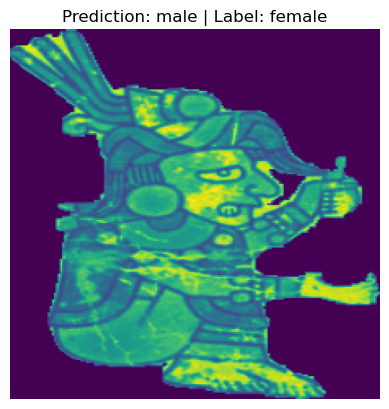

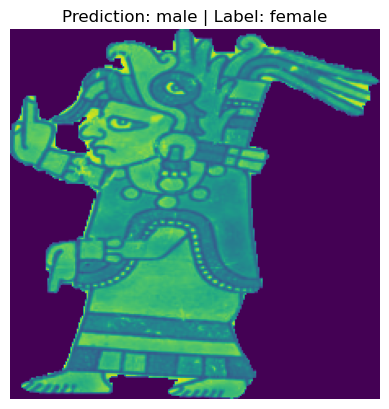

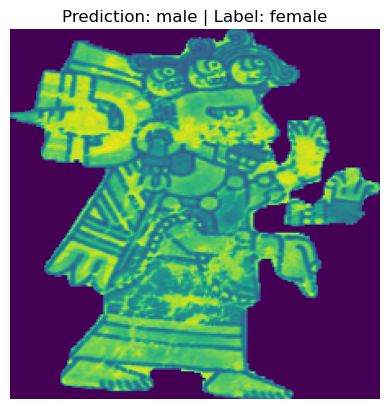

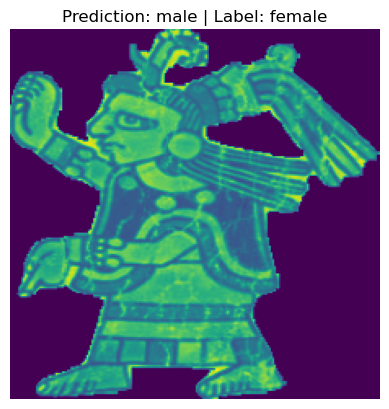

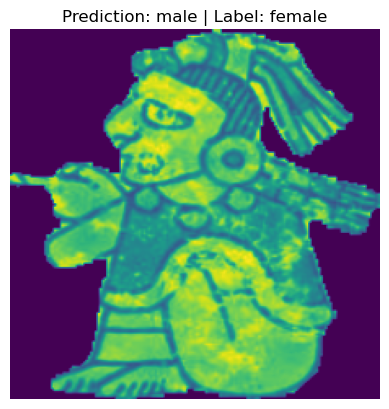

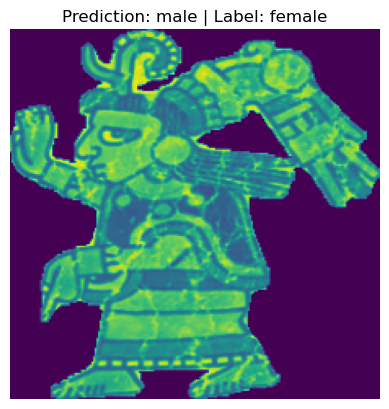

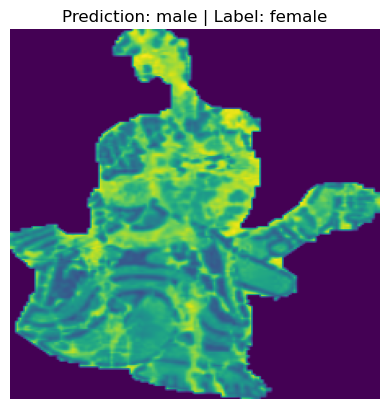

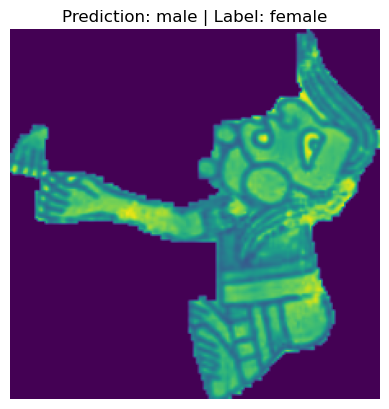

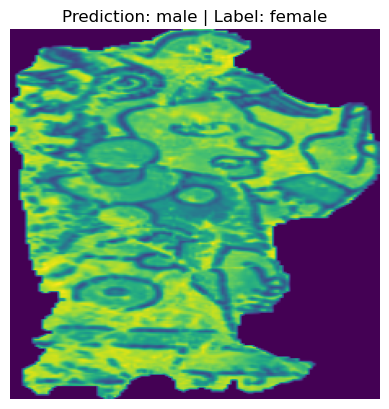

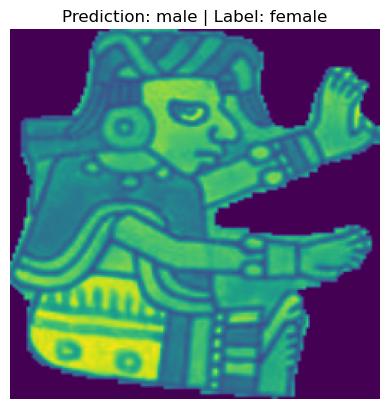

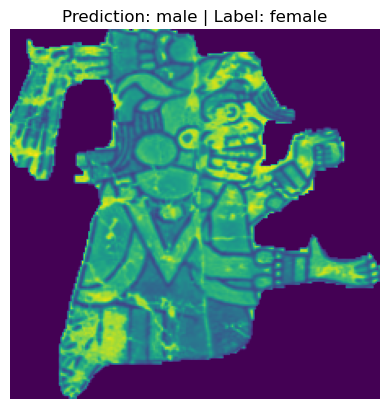

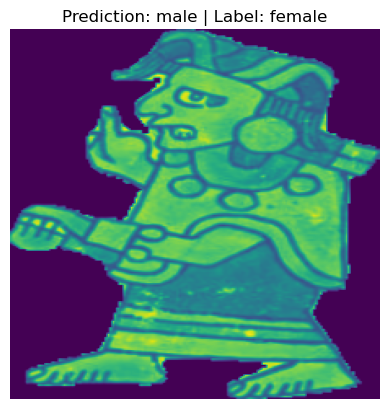

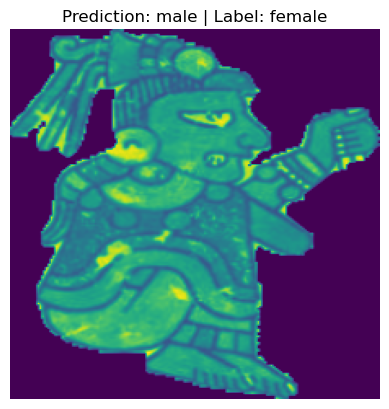

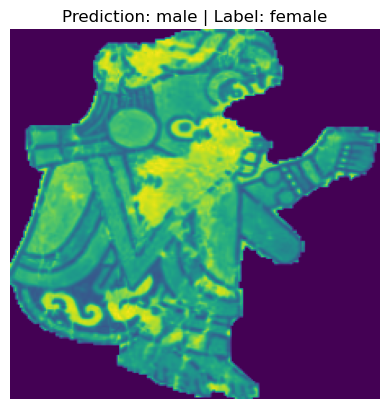

In [82]:
for i, data in enumerate(train_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    
    outputs = cnn(images)
    
    _, predictions = torch.max(outputs, 1)
    
    correct = 0
    total = len(predictions)
    for label, image, prediction in zip(labels, images, predictions):
        if label != prediction:
            image = image.permute(1, 2, 0)
            image = image.cpu().numpy()

            plt.imshow(image)
            plt.title("Prediction: " + class_map[prediction.item()] + " | Label: " + class_map[label.item()])
            plt.axis('off')
            plt.show()


            

### Save model

In [83]:
savepath = "../models/mixtec_gender_classifier.pth"

torch.save(cnn.state_dict(), savepath)

### Visualize learning

In [84]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mixtec_experiment_gender')

### Define tensorboard output function

In [85]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize1
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Output sample heatmap of selected features

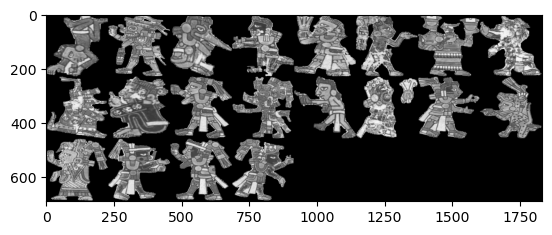

In [86]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mixtec_genders', img_grid)

# Testing

### Load images and labels from test_loader

In [87]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [88]:
cnn = CNN()
cnn.load_state_dict(torch.load(savepath))
cnn.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Produce predictions and calculate accuracy of model

In [89]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

Accuracy of the network on the 42 test images: 90 %
